# Lista prática I

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

## Vizinhos mais próximos

**Exercício 1.** O código abaixo carrega o dataset MNIST, que consiste em imagens de dígitos entre $0$ e $9$. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 5) e reporte a acurácia para cada valor de $k$. Lembre que a acurácia é o percentual de amostras classificadas corretamente. Notavelmente, as entradas do MNIST tem dimensão relativamente alta (64). Plote uma imagem com a variância amostral dos pixels das imagens e comente. Também mostre as imagens classificadas de maneira errônea e comente.

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)

@dataclass
class Dataset:
    features_train: np.ndarray 
    features_test: np.ndarray  
    labels_train: np.ndarray   
    labels_test: np.ndarray

# Import dataset and separate train/test subsets
mnist = Dataset(*train_test_split(
    *load_digits(return_X_y=True),
    random_state=SEED,
))

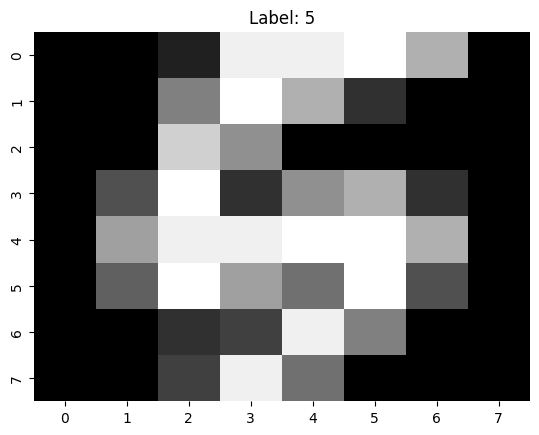

In [2]:
# Visualizing the data
_n = 0
sns.heatmap(mnist.features_train[_n].reshape(8, 8), cmap='gray', cbar=False)
plt.title(f"Label: {mnist.labels_train[_n]}")
plt.show()

In [3]:
from collections import Counter

class KNNClassifier:
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        if self.X_train is None or self.y_train is None:
            raise ValueError("Model has not been fitted yet.")
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_idx = np.argsort(distances)[: self.k]
            k_labels = self.y_train[k_idx]
            most_common = Counter(k_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

In [4]:
for k in range(1, 6):
    knn = KNNClassifier(k)
    knn.fit(mnist.features_train, mnist.labels_train)
    preds = knn.predict(mnist.features_test)
    acc = np.mean(preds == mnist.labels_test)
    print(f"k = {k}: Acurácia = {acc:.2%}")

k = 1: Acurácia = 98.22%
k = 2: Acurácia = 98.22%
k = 3: Acurácia = 98.67%
k = 4: Acurácia = 98.67%
k = 5: Acurácia = 99.11%


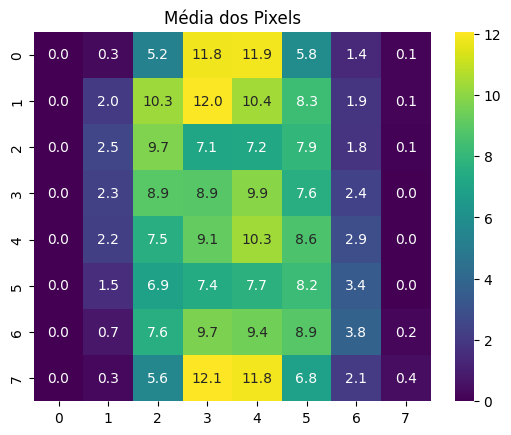

In [5]:
pixel_mean = np.mean(mnist.features_train, axis=0)
sns.heatmap(pixel_mean.reshape(8, 8), cmap='viridis', annot=True, fmt=".1f")
plt.title("Média dos Pixels")
plt.show()

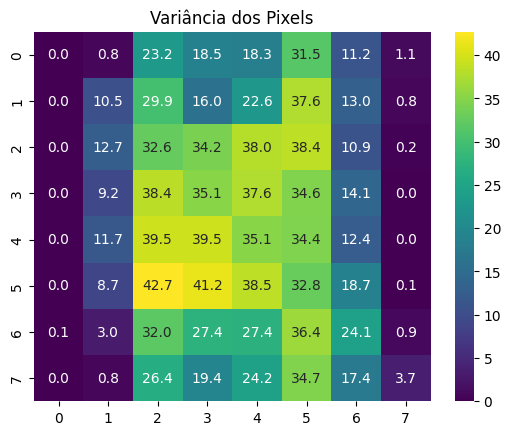

In [6]:
pixel_var = np.var(mnist.features_train, axis=0)
sns.heatmap(pixel_var.reshape(8, 8), cmap='viridis', annot=True, fmt=".1f")
plt.title("Variância dos Pixels")
plt.show()

É notável que a 1ª e última colunas tem uma variância muito baixa, o que indica que esses valores praticamente não mudam entre as imagens. Isso significa que esses pixels não são informativos para a classificação. Além disso, a 2ª e penúltima colunas também têm uma variância relativamente baixa, o que sugere que esses pixels podem ser menos informativos. As colunas mais informativas são as do meio, que apresentam uma variância mais alta.

In [7]:
knn_best = KNNClassifier(5)
knn_best.fit(mnist.features_train, mnist.labels_train)
preds_best = knn_best.predict(mnist.features_test)
errors_idx = np.where(preds_best != mnist.labels_test)[0]
errors_idx

array([ 71, 133, 159, 249])

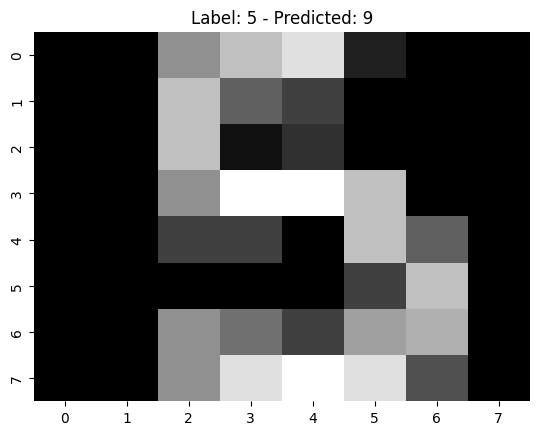

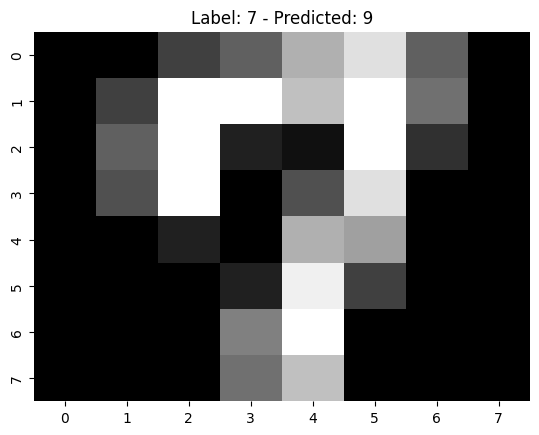

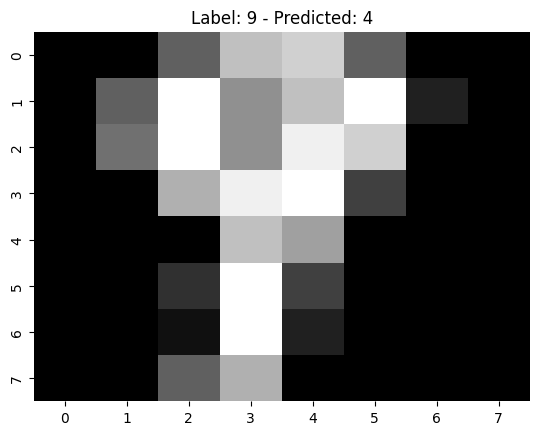

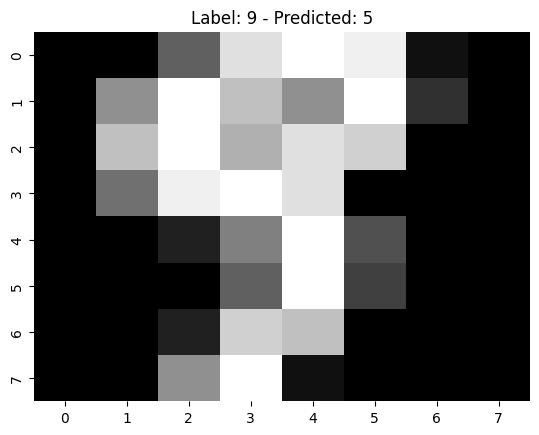

In [8]:
for idx in errors_idx:
    sns.heatmap(mnist.features_test[idx].reshape(8, 8), cmap='gray', cbar=False)
    plt.title(f"Label: {mnist.labels_test[idx]} - Predicted: {preds_best[idx]}")
    plt.show()

Os casos em que o classificador errou foram realmente difíceis. Até mesmo humanos teriam dificuldade em classificar esses dígitos. Isso ocorre pois estes dígitos costumam ter regiões de pixels similares.

**Exercício 02.** O código abaixo carrega o dataset "two moons", que consiste de amostras bidimensionais divididas em duas classes. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 10). Plote a superfície de decisão para cada valor de $k$. Como $k$ influencia na suavidade dessas superfícies?

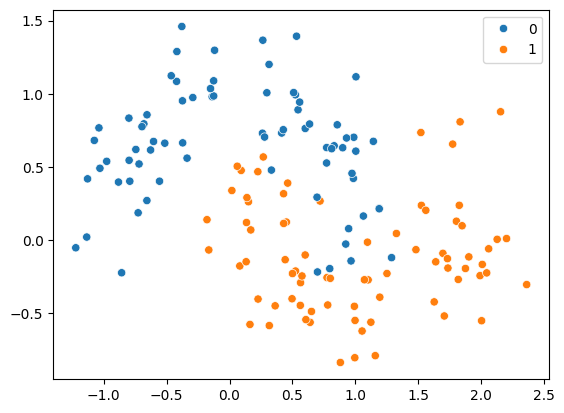

In [9]:
# Import dataset and separate train/test subsets
moon = Dataset(*train_test_split(
    *make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=SEED),
    random_state=SEED,
))

# Let's also plot the moon dataset, for you to take a look at it.
sns.scatterplot(
    x=moon.features_train[:, 0],
    y=moon.features_train[:, 1],
    hue=moon.labels_train,
)
plt.show()

In [10]:
acc_by_k = {}
for k in [*range(1, 11), 100]:
    knn = KNNClassifier(k)
    knn.fit(moon.features_train, moon.labels_train)
    preds = knn.predict(moon.features_test)
    acc = np.mean(preds == moon.labels_test)
    print(f"k = {k}: Acurácia = {acc:.2%}")
    acc_by_k[k] = acc

k = 1: Acurácia = 94.00%
k = 2: Acurácia = 94.00%
k = 3: Acurácia = 92.00%
k = 4: Acurácia = 92.00%
k = 5: Acurácia = 92.00%
k = 6: Acurácia = 94.00%
k = 7: Acurácia = 94.00%
k = 8: Acurácia = 94.00%
k = 9: Acurácia = 94.00%
k = 10: Acurácia = 94.00%
k = 100: Acurácia = 80.00%


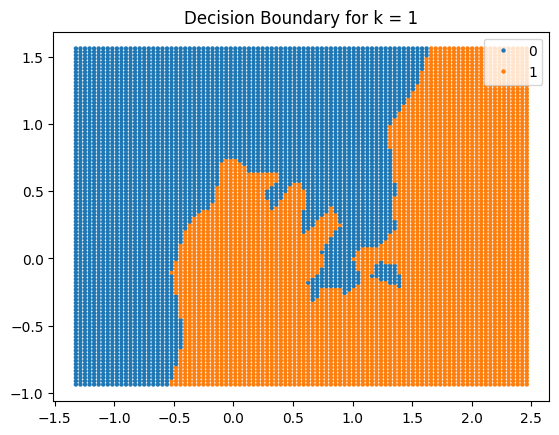

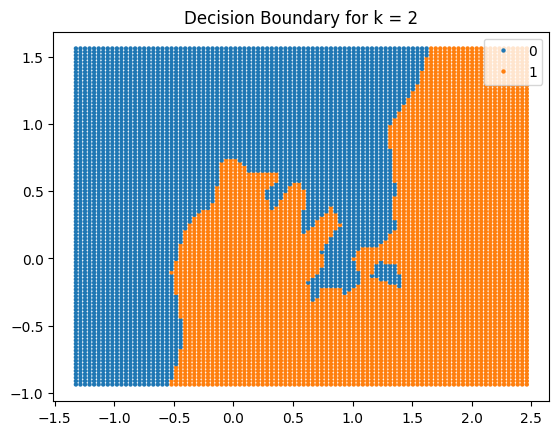

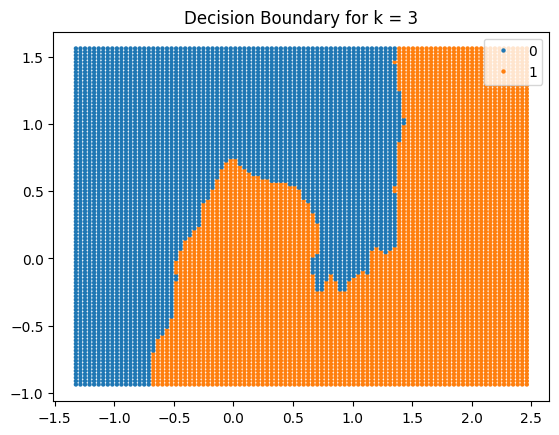

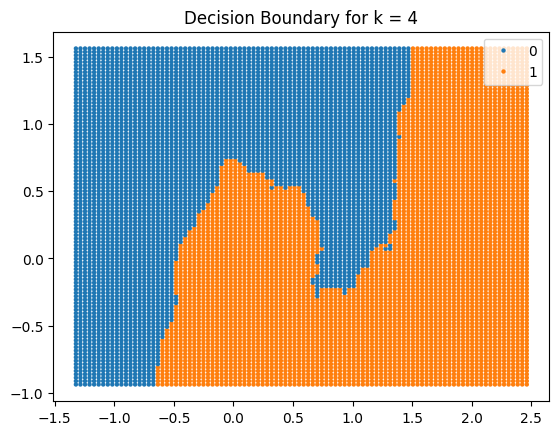

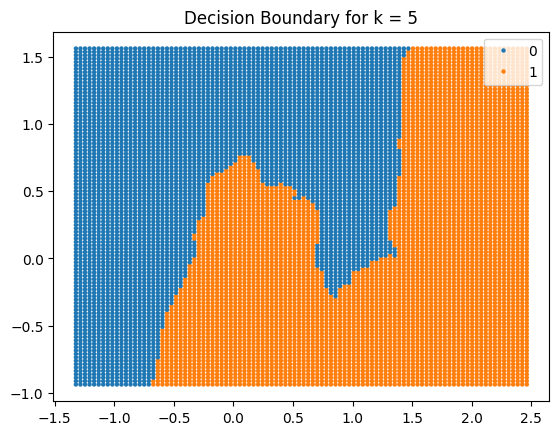

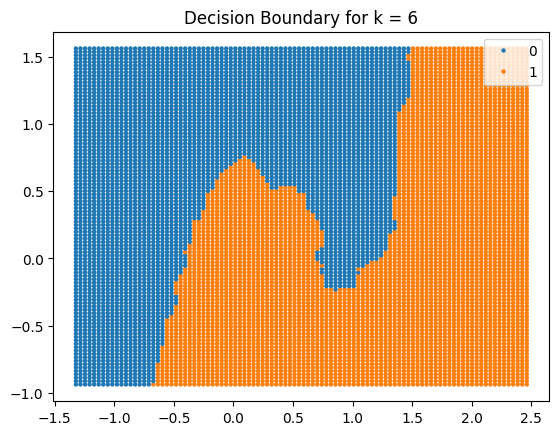

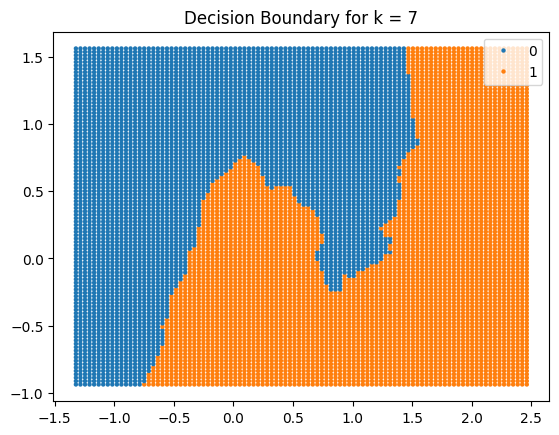

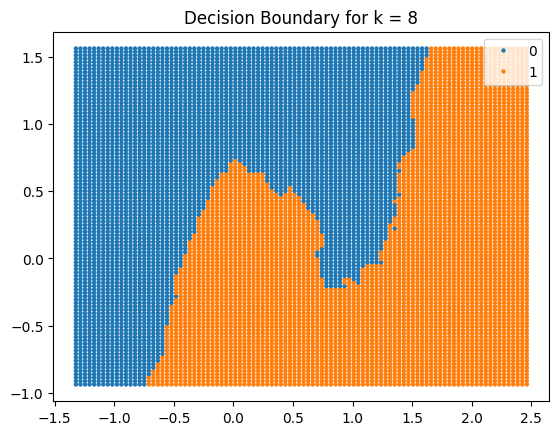

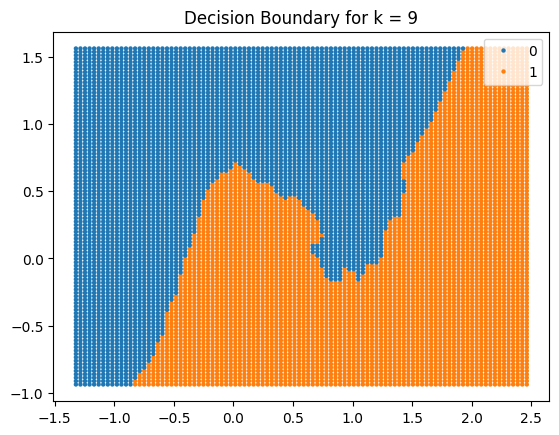

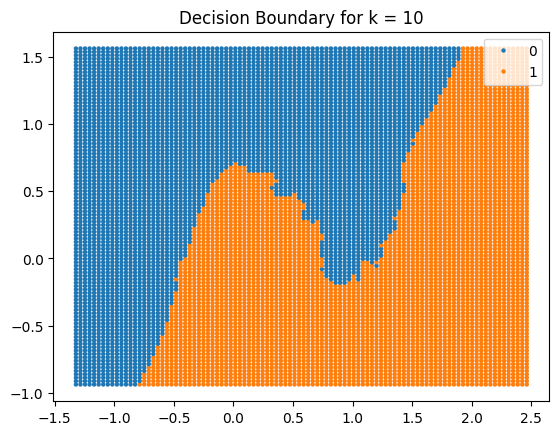

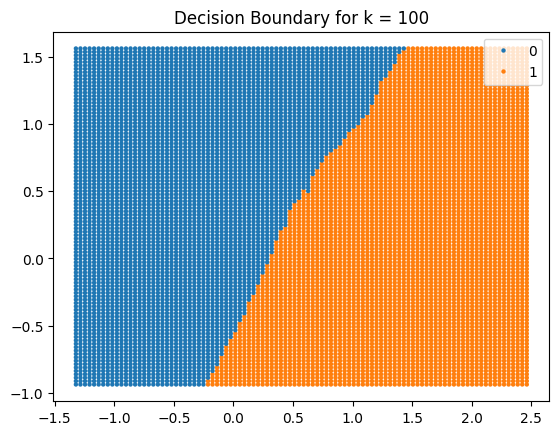

In [11]:
import itertools

margin = 0.1
f1_arr = np.linspace(
    moon.features_train[:, 0].min() - margin,
    moon.features_train[:, 0].max() + margin,
    num=100
)
f2_arr = np.linspace(
    moon.features_train[:, 1].min() - margin,
    moon.features_train[:, 1].max() + margin,
    num=100
)

X_decision_boundary = np.array(list(itertools.product(f1_arr, f2_arr)))

boundary_preds_by_k = {}
for k in [*range(1, 11), 100]:
    knn = KNNClassifier(k)
    knn.fit(moon.features_train, moon.labels_train)
    preds = knn.predict(X_decision_boundary)
    boundary_preds_by_k[k] = preds
    sns.scatterplot(
        x=X_decision_boundary[:, 0],
        y=X_decision_boundary[:, 1],
        hue=preds,
        s=10,
        edgecolor="none",
    )
    plt.title(f"Decision Boundary for k = {k}")
    plt.show()

Quanto maior o $k$, mais suave é a superfície de decisão — até o ponto em que ela pode ficar suave demais e perder capacidade de capturar padrões.